# Electrochemical mapping analysis of LIB
This notebook walks through the electrochemical mapping analysis of the LIB. This uses the fit files generated by `gen_lib_fits.py`.

In [21]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib widget
from copy import deepcopy
import glob
from pathlib import Path
from scipy.optimize import least_squares
from scipy.integrate import cumtrapz
from scipy.special import factorial
from scipy import ndimage
from scipy.signal import find_peaks
from skimage import filters
import time
import seaborn as sn
import pandas as pd
import pickle

from cmdstanpy import CmdStanModel

from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

import hybdrt
from hybdrt.models import DRT
from hybdrt.models.sequential import fit_sequence
import hybdrt.fileload as fl
import hybdrt.plotting as hplt
import hybdrt.preprocessing as pp
from hybdrt.mapping.stan_utils import load_model

from hybdrt import mapping

import battmap.fit
import battmap.dataload as dl
from battmap import sequence, capacity, surface, stan_utils
from battmap.reader import ReaderCollection
from battmap.plot import plot_x_2d, plot_drt_2d, plot_dop_2d
from battmap import analysis

import fig_funcs as ff

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Set paths
datadir = Path('../data/LIB/mapping')
fit_path = Path('./fits/LIB')

tot_cap = 3400

In [3]:
# Set plot formatting
full_width, half_width, light_colors, base_colors, dark_colors = ff.set_plot_formatting()
data_kw = dict(facecolors='none', edgecolors=[0.1] * 3)
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Set tau limits for DOP normalization
# NOTE: these values are different from those in LIB_basic.ipynb.
# These values were chosen to give the HF, LF, and ohmic DOP peaks similar magnitudes 
# so that the DOP can be visualized effectively in 2D.
norm_tau = (5e-5, 3e1)

In [4]:
# Helper functions
def save_pickle(obj, dest):
    with open(dest, 'wb') as f:
        pickle.dump(obj, f, pickle.DEFAULT_PROTOCOL)
        
def load_pickle(src):
    with open(src, 'rb') as f:
        out = pickle.load(f)
    return out

# Conversion between capacity and SOC
def cap_to_soc(cap):
    return 100 * (1 - (cap / tot_cap))

def soc_to_cap(soc):
    return 100 * (1 - soc) * tot_cap
    
def integrate_dop(x_dop, mrt, omega_neg, omega_pos):
    # Integrate the DOP to obtain the effective impedance magnitude
    # at a fixed frequency
    func = hybdrt.matrices.phasance.get_phasor_impedance_func(mrt.nu_basis_type)
    zvec_neg = func(omega_neg, mrt.fixed_basis_nu[mrt.fixed_basis_nu < 0], mrt.nu_epsilon)
    zvec_pos = func(omega_pos, mrt.fixed_basis_nu[mrt.fixed_basis_nu > 0], mrt.nu_epsilon)
    
    for i in range(np.ndim(x_dop) - 1):
        zvec_neg = np.expand_dims(zvec_neg, axis=0)
        zvec_pos = np.expand_dims(zvec_pos, axis=0)
    z_neg = x_dop[..., mrt.fixed_basis_nu < 0] * zvec_neg
    z_pos = x_dop[..., mrt.fixed_basis_nu > 0] * zvec_pos
    
    
    return np.sum(np.abs(z_neg), axis=-1), np.sum(np.abs(z_pos), axis=-1)

## Generate discharge curves from hybrid spectra
Extract DC current and voltage from operando hybrid spectra to construct discharge curves.

In [5]:
# Load pre-processed data (generated by gen_lib_fits.py)
test_data = analysis.process_discharge_curves(datadir, tot_cap, pickledir=fit_path, 
                                              suffix='_doplambda=50_NormBySupergrid_wf1.5')

discharge_data = {k: v['discharge'] for k, v in test_data.items()}

Test 1
Test 2
Test 3
Test 4
Test 5
Test 6
Test 7
Test 8
Test 9
Test 10
Test 11
Test 12
Test 13
Test 14
Test 15


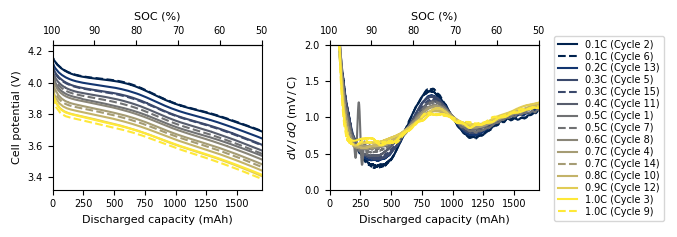

In [41]:
# Supp fig: plot differential discharge curves
fig, axes = plt.subplots(1, 2, figsize=(full_width, full_width * 0.35))

# Set colormap for C rate
c_norm = mpl.colors.Normalize(vmin=0.1, vmax=1.)
c_cmap = mpl.cm.get_cmap('cividis')


for c_rate in np.arange(0.1, 1.01, 0.1):
        keys = [k for k, v in discharge_data.items() if v['c_rate'] == round(c_rate, 1)]
        
        for i, key in enumerate(keys):
            if i > 0:
                ls = '--'
            else:
                ls = '-'
                
            # Use measured data for discharge curve
            times, i_sig, v_sig = discharge_data[key]['cp_seq_tup']
            plot_cap = discharge_data[key]['plot_cap']
            
            axes[0].plot(plot_cap, v_sig, label='{}C (Cycle {})'.format(discharge_data[key]['c_rate'], key), 
                    ls=ls, color=c_cmap(c_norm(c_rate)))
            
            # Use model data for differential curve
            times, i_sig, v_sig = discharge_data[key]['pred_tup']
            plot_cap = discharge_data[key]['pred_plot_cap']
            
            axes[1].plot(plot_cap[11:], np.abs(np.diff(v_sig) / np.diff(plot_cap))[10:] * 3600, 
                    label='{}C (Cycle {})'.format(discharge_data[key]['c_rate'], key), 
                    ls=ls, color=c_cmap(c_norm(c_rate)))
        
axes[1].legend(fontsize=7, loc='upper left', bbox_to_anchor=(1.05, 1.1), labelspacing=0.2)

for ax in axes:
    ax.set_xlabel('Discharged capacity (mAh)')
    ax.set_xlim(0, tot_cap / 2)
    
    xax2 = ax.secondary_xaxis('top', functions=(cap_to_soc, soc_to_cap))
    xax2.set_xlabel('SOC (%)')
    xax2.set_xticks(np.arange(50, 101, 10))

    
axes[0].set_ylabel('Cell potential (V)')
axes[1].set_ylabel('$dV \, / \, dQ$ (mV$\,$/$\,$C)')

axes[1].set_ylim(0, 2)

fig.tight_layout()

# ff.savefig(fig, 'Supp_LIB_dVdQ')

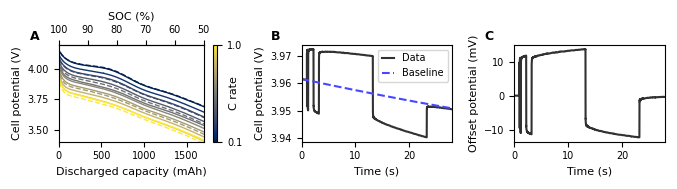

In [208]:
# Supp fig: Show discharge curves and chronopotentiometry voltage offset
# ----------------------------------------------------------------------

# Set up chrono reader for chrono offset illustration
test_id = 1
testdir = next(datadir.glob(f'Test{test_id}_*'))
run_id = 2
chrono_file = next(testdir.glob(f'CHRONOP_DISCHARGE*Cycle{run_id}_*Filtered.DTA'))
eis_file = next(testdir.glob(f'EISGALV_DISCHARGE*Cycle{run_id}.DTA'))

cp_tup = fl.read_chrono(chrono_file, return_tuple=True)
eis_tup = fl.read_eis(eis_file, return_tuple=True)

drt_seq = test_data[test_id]['discharge']['drt_seq']
offset_reader = sequence.make_chrono_reader(test_data[test_id]['discharge']['init_timestamp'], 
                                            drt_seq)
cp_tup_offset = offset_reader(chrono_file)
# fig, axes = plt.subplots(1, 3, figsize=(full_width, full_width * 0.28))
fig = plt.figure(figsize=(full_width, full_width * 0.28))
gs = fig.add_gridspec(1, 3, width_ratios=(1.2, 1, 1))
axes = [fig.add_subplot(gs[i]) for i in range(3)]

discharge_ax = axes[0]
cp_offset_axes = axes[1:]

# Plot discharge curves
#----------------------
for c_rate in np.arange(0.1, 1.01, 0.1):
    keys = [k for k, v in discharge_data.items() if v['c_rate'] == round(c_rate, 1)]

    for i, key in enumerate(keys):
        # Plot repeat tests with dashed line
        if i > 0:
            ls = '--'
        else:
            ls = '-'

        # Use measured data for discharge curve
        times, i_sig, v_sig = discharge_data[key]['cp_seq_tup']
        plot_cap = discharge_data[key]['plot_cap']

        discharge_ax.plot(plot_cap, v_sig, label='{}C (Cycle {})'.format(discharge_data[key]['c_rate'], key), 
                ls=ls, color=c_cmap(c_norm(c_rate)), lw=1)
        
sm = mpl.cm.ScalarMappable(norm=c_norm, cmap=c_cmap)
cb = fig.colorbar(sm, ax=discharge_ax)
cb.set_ticks([0.1, 1])
cb.set_label('C rate', labelpad=-10)
        
# discharge_ax.legend(fontsize=7, loc='upper left', bbox_to_anchor=(1.05, 1.0))

xax2 = discharge_ax.secondary_xaxis('top', functions=(cap_to_soc, soc_to_cap))
xax2.set_xlabel('SOC (%)')
xax2.set_xticks(np.arange(50, 101, 10))

discharge_ax.set_xlabel('Discharged capacity (mAh)') 
discharge_ax.set_ylabel('Cell potential (V)')
discharge_ax.set_xlim(0, tot_cap / 2)
discharge_ax.set_ylim(3.4, 4.2)

# Illustrate chrono data offset
# -----------------------------
v_pred = drt_seq.predict_response(cp_tup_offset[0], subtract_background=False)
hplt.plot_chrono(cp_tup, axes=cp_offset_axes[0], plot_i=False, label='Data', 
                 plot_func='plot', alpha=0.9,
                 c=data_kw['edgecolors'])
hplt.plot_chrono((cp_tup[0], None, v_pred), axes=cp_offset_axes[0], plot_func='plot', 
                 c=light_colors[0], ls='--',
                 label='Baseline')
hplt.plot_chrono((cp_tup[0], None, cp_tup_offset[2]), axes=cp_offset_axes[1],
                 plot_func='plot',
                 alpha=0.9,
                 c=data_kw['edgecolors'])

cp_offset_axes[0].legend(fontsize=7, handlelength=1.3)
cp_offset_axes[0].set_ylabel('Cell potential (V)')
cp_offset_axes[1].set_ylabel('Offset potential (mV)')

for ax in cp_offset_axes:
    ax.set_xlabel('Time (s)')
    ax.set_xlim(0, 28)
    

fig.tight_layout()
ff.add_letters(axes, loc=(-0.2, 1.15))

# ff.savefig(fig, 'Supp_LIB_DischargeCurves')

## Mapping analysis
The actual mapping analysis begins here. First, we do some data cleaning to remove corrupted measurements, which inevitably arise during high-throughput automated measurements.

In [6]:
# Load DRT-DOP fits generated by gen_lib_fits.py
mrt_rbf = None
suffix = '_doplambda=50_NormBySupergrid_wf1.5'
prefix = ''
for test_id in range(1, 16):
    if mrt_rbf is None:
        mrt_rbf = mapping.DRTMD.from_source(fit_path.joinpath(f'{prefix}Fits_Test{test_id}{suffix}.pkl'))
    else:
        mrt_rbf.load_observations(fit_path.joinpath(f'{prefix}Fits_Test{test_id}{suffix}.pkl'))

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


In [7]:
# Set SOC grid for visualization
soc_grid = np.linspace(0.5, 1.0, 51)


In [8]:
# Flag bad observations (corrupted spectra) by examining each fit in the context of the entire dataset
groups = np.unique(mrt_rbf.obs_group_id)
for group in groups:
    index = mrt_rbf.get_group_index(group)
    x_raw = mrt_rbf.obs_x[index]
    soc_vals = mrt_rbf.obs_psi[index, mrt_rbf.psi_dim_names.index('soc')]
    sort_index = np.argsort(soc_vals)
    x_raw = x_raw[sort_index]
    index = index[sort_index]

    x_filt = ndimage.median_filter(x_raw, size=(5, 1))

    bad_flag = mapping.nddata.flag_bad_obs(x_raw, x_filt, std_size=(5, 3), thresh=1, 
                                           test_factor_correction=False, test_offset_correction=False,
                                           return_rss=False, robust_std=True)
    
    bad_obs_flag = np.max(bad_flag, axis=1)
    mrt_rbf.obs_ignore_flag[index] = bad_obs_flag

    print(f'{group} num bad:', np.sum(np.max(bad_flag, axis=1)))

10_CHARGE num bad: 0
10_DISCHARGE num bad: 0
11_CHARGE num bad: 0
11_DISCHARGE num bad: 1
12_CHARGE num bad: 0
12_DISCHARGE num bad: 1
13_CHARGE num bad: 0
13_DISCHARGE num bad: 1
14_CHARGE num bad: 0
14_DISCHARGE num bad: 0
15_CHARGE num bad: 0
15_DISCHARGE num bad: 0
1_CHARGE num bad: 0
1_DISCHARGE num bad: 2
2_CHARGE num bad: 0
2_DISCHARGE num bad: 1
3_CHARGE num bad: 0
3_DISCHARGE num bad: 2
4_CHARGE num bad: 0
4_DISCHARGE num bad: 0
5_CHARGE num bad: 0
5_DISCHARGE num bad: 0
6_CHARGE num bad: 0
6_DISCHARGE num bad: 1
7_CHARGE num bad: 0
7_DISCHARGE num bad: 0
8_CHARGE num bad: 0
8_DISCHARGE num bad: 0
9_CHARGE num bad: 0
9_DISCHARGE num bad: 1


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\mapping\nddata.py:205: RuntimeWarning: invalid value encountered in true_divide
  resid = np.nan_to_num((xri - xfi) / x_std)


In [9]:
# Perform batch refinement of groups after flagging bad observations
# NOTE: only discharge cycles were fitted, so charge cycles will take 0 time
for group in np.unique(mrt_rbf.obs_group_id):
    start = time.time()
    mrt_rbf.resolve_group(group, psi_sort_dims=['soc'], 
                        sigma=0.75, lambda_psi=140, batch_size=7,
                        tau_filter_sigma=0, special_filter_sigma=0)
    print('Group {} resolve time: {:.1f} s'.format(group, time.time() - start))

Group 10_CHARGE resolve time: 0.0 s
Group 10_DISCHARGE resolve time: 7.1 s
Group 11_CHARGE resolve time: 0.0 s
Group 11_DISCHARGE resolve time: 7.2 s
Group 12_CHARGE resolve time: 0.0 s
Group 12_DISCHARGE resolve time: 7.7 s
Group 13_CHARGE resolve time: 0.0 s
Group 13_DISCHARGE resolve time: 5.6 s
Group 14_CHARGE resolve time: 0.0 s
Group 14_DISCHARGE resolve time: 5.7 s
Group 15_CHARGE resolve time: 0.0 s
Group 15_DISCHARGE resolve time: 5.6 s
Group 1_CHARGE resolve time: 0.0 s
Group 1_DISCHARGE resolve time: 6.8 s
Group 2_CHARGE resolve time: 0.0 s
Group 2_DISCHARGE resolve time: 6.3 s
Group 3_CHARGE resolve time: 0.0 s
Group 3_DISCHARGE resolve time: 4.9 s
Group 4_CHARGE resolve time: 0.0 s
Group 4_DISCHARGE resolve time: 6.0 s
Group 5_CHARGE resolve time: 0.0 s
Group 5_DISCHARGE resolve time: 6.1 s
Group 6_CHARGE resolve time: 0.0 s
Group 6_DISCHARGE resolve time: 7.3 s
Group 7_CHARGE resolve time: 0.0 s
Group 7_DISCHARGE resolve time: 7.3 s
Group 8_CHARGE resolve time: 0.0 s
Grou

## Evaluate hypersurface structure
Now we can generate the DRT and DOP hypersurfaces from the individual DRT-DOP fits.

In [10]:
# Generate hypersurface structure from multi-dimensional DRT
struct_results = surface.structure_from_drtmd(mrt_rbf, soc_grid, 
                                              soc_dist_thresh=np.median(np.diff(soc_grid)) * 0.7
                                              )

C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\filters\_filters.py:175: RuntimeWarning: invalid value encountered in true_divide
  return x_filt / mask_filt
c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\numpy\lib\nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
C:\Users\jdh10\OneDrive - Colorado School of Mines\pytho

In [12]:
func = lambda x: 10 * struct_results[x]['c_rate'] + 0.01 * float(x.split('_')[0])
keys = [k for k in struct_results.keys() if k.split('_')[1] == 'DISCHARGE']
dict(zip(keys, [func(k) for k in keys]))

{'10_DISCHARGE': -7.9,
 '11_DISCHARGE': -3.89,
 '12_DISCHARGE': -8.88,
 '13_DISCHARGE': -1.87,
 '14_DISCHARGE': -6.86,
 '15_DISCHARGE': -2.85,
 '1_DISCHARGE': -4.99,
 '2_DISCHARGE': -0.98,
 '3_DISCHARGE': -9.97,
 '4_DISCHARGE': -6.96,
 '5_DISCHARGE': -2.95,
 '6_DISCHARGE': -0.94,
 '7_DISCHARGE': -4.93,
 '8_DISCHARGE': -5.92,
 '9_DISCHARGE': -9.91}

In [11]:
# Stack 2D tau-SOC surfaces along C-rate dimension to get 3D hypersurface
# Stack is ordered by C_rate and test_id
rp_stack = []
tp_stack = []
f_stack = []
R_inf_stack = []
Rp_stack = []
Rp_hf_stack = []
R_lf_stack = []
x_dop_stack = []
time_stack = []
test_stack = []

# Sort keys by c_rate and test_id
sorted_keys = [k for k in struct_results.keys() if k.split('_')[1] == 'DISCHARGE']
sorted_keys = sorted(sorted_keys, key=lambda x: 10 * struct_results[x]['c_rate'] - 0.01 * float(x.split('_')[0]))[::-1]
test_id_list = [int(k.split('_')[0]) for k in sorted_keys]

c_rates = np.array([struct_results[key]['c_rate'] for key in sorted_keys])

# Set low-frequency (long-timescale) cutoff
# Anything at timescales longer than 10^-0.5 s is considered 
# part of the low-frequency transport process corresponding to the LF DOP peak
lf_index = hybdrt.utils.array.nearest_index(mrt_rbf.tau_supergrid, 10 ** -0.5)

for key in sorted_keys:
    if key.split('_')[1] == 'DISCHARGE':
        # rp: ridge probability
        rp_stack.append(struct_results[key]['rp_raw'])
        # tp: trough probability
        tp_stack.append(struct_results[key]['tp_filt'])
        
        # x_filt: refined and filtered DRT coefficients
        x_filt = struct_results[key]['x_filt']
        # gamma: refined and filtered DRT surface
        gamma = mrt_rbf.predict_drt(psi=None, x=x_filt, tau=mrt_rbf.tau_supergrid)
        f_stack.append(gamma)
        
        # R_inf: ohmic resistance
        R_inf_stack.append(struct_results[key]['R_inf_filt'])
        
        # Rp: polarization resistance
        Rp_stack.append(np.trapz(gamma, x=np.log(mrt_rbf.tau_supergrid), axis=-1))
        
        # R_lf: DRT resistance at tau > low-freq cutoff
        R_lf_stack.append(np.trapz(gamma[..., lf_index:], 
                                   x=np.log(mrt_rbf.tau_supergrid[lf_index:]), 
                                   axis=-1))
        
        # x_dop: refined and filtered DOP parameters
        x_dop_stack.append(struct_results[key]['x_dop_filt'])
        
        # time_stack: elapsed time
        time_arr = struct_results[key]['psi'][:, 3]
        time_stack.append(time_arr)
        
        # test_stack: test_id (cycle number) 
        test_stack.append(np.ones(time_arr.shape) * float(key.split('_')[0]))
    
rp_stack = np.stack(rp_stack)
tp_stack = np.stack(tp_stack)
f_stack = np.stack(f_stack)
R_inf_stack = np.stack(R_inf_stack)
Rp_stack = np.stack(Rp_stack)
R_lf_stack = np.stack(R_lf_stack)
x_dop_stack = np.stack(x_dop_stack)

# Integrate DOP peaks
z_neg_stack, z_pos_stack = integrate_dop(x_dop_stack, mrt_rbf, 0.1, 1e5 * 2 * np.pi)
time_stack = np.stack(time_stack)
test_stack = np.stack(test_stack)

# Transport peak: includes long-timescale DRT peak and pseudo-capacitive DOP peak
R_trans_stack = R_lf_stack + z_neg_stack

In [14]:
test_id_list

[2, 6, 13, 5, 15, 11, 1, 7, 8, 4, 14, 10, 12, 3, 9]

## Find sheets
Use sheet-tracing algorithm to identify sheets in the DRT hypersurface ("sheet" and "path" are used interchangeably in the variable naming convention and comments, as the sheet-tracing algorithm is based on the concept of path-finding).

In [24]:
# Filter ridge prob for path finding
rp_stack_f = mapping.ndx.filter_ndx(rp_stack, num_group_dims=1, by_group=False,
                                    iterative=True, iter=3, nstd=5, dev_rms_size=5,
                                    adaptive=True, impute=False, impute_groups=False,
                                    max_sigma=(2, 4, 0), k_factor=(4, 4, 1),
                                    presmooth_sigma=None,
                                    mode='nearest'
                                    )

# Find paths (sheets)
all_paths, costs = mapping.path.find_paths_3d(rp_stack_f, 50, 0, 
                                          grad_strength=10, grad_sigma=0,
                                          height=0.1, prominence=0.01, max_slope=0.5, 
                                          min_prob=0., offset=1, momentum=0.1, 
                                          slope_offset_cost=1,
                                          offset_cost=1,
                                         )

all_path_tau = mapping.path.get_path_tau(mrt_rbf.tau_supergrid, all_paths, shape=rp_stack_f.shape)

# Exclude transport sheet(s) at tau > tau_lf since the transport process is quantified separately
paths = all_paths[:4]

best_slope: -0.03333333333333344
best_slope: -0.03333333333333344
best_slope: -0.2333333333333334
best_slope: -0.03333333333333344
best_slope: -0.16666666666666674
best_slope: -0.03333333333333344


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\mapping\path.py:76: RuntimeWarning: divide by zero encountered in log
  return -np.log(ridge_prob)


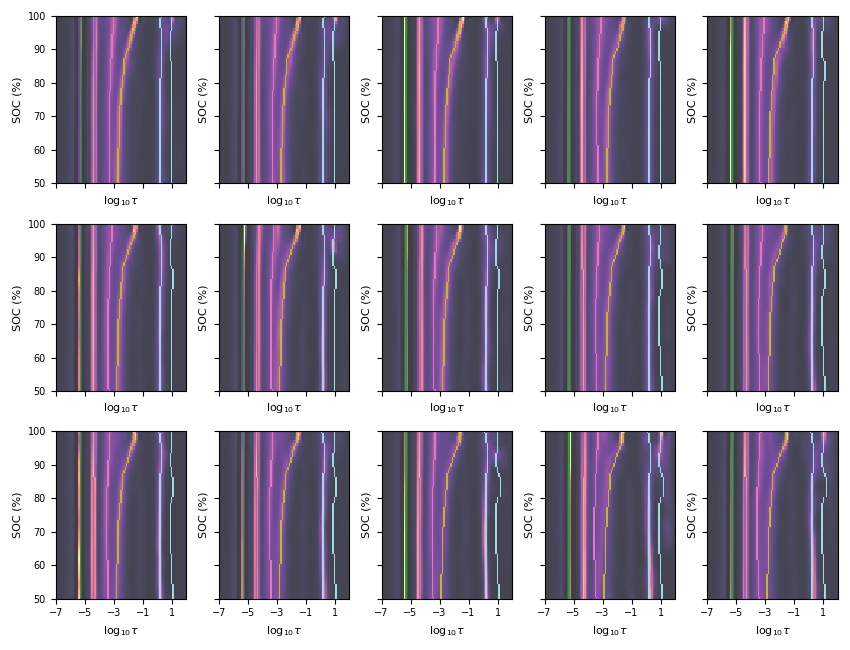

In [25]:
# Show sheets/paths overlaid with ridge prob
# NOTE: the two longest-timescale sheets are assigned to the LF transport process,
# and are therefore excluded from the GP-ZARC model
path_mask = mapping.path.paths_to_mask_3d(rp_stack.shape, all_paths, True, fill_nan=True)

fig, axes = plt.subplots(3, 5, figsize=(8.5, 6.5), sharex=True, sharey=True)

for i, ax in enumerate(axes.ravel()):
    plot_x_2d(rp_stack[i], soc_grid, mrt_rbf, ax=ax, vmin=0, vmax=1, cmap='magma', alpha=0.75)
    x_plot = path_mask[i]
    plot_x_2d(x_plot, soc_grid, mrt_rbf, ax=ax, vmin=0, vmax=5, cmap='tab20')

fig.tight_layout()

In [26]:
# Get sheet time constant as function of SOC and C-rate
path_tau = mapping.path.get_path_tau(mrt_rbf.tau_supergrid, paths, shape=rp_stack_f.shape)

# Integrate to estimate resistance
path_dist, path_sizes = mapping.path.integrate_paths(
    mrt_rbf.tau_supergrid[:lf_index], f_stack[..., :lf_index], 
    paths, 
    widths=[5, 6, 7, 8],
    smooth=True, smooth_sigma=(0.5, 3)
)

(15, 51, 65)
0 2.5
(15, 51, 65)
1 3.0
(15, 51, 65)
2 3.5
(15, 51, 65)
3 4.0


In [27]:
# Get all sheets (including LF paths) for visualization
all_path_tau = mapping.path.get_path_tau(mrt_rbf.tau_supergrid, all_paths, shape=rp_stack_f.shape)
all_path_tau.shape

(6, 15, 51)

C:\Users\jdh10\AppData\Local\Temp\ipykernel_17712\2695392259.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([-6, '', -4, '', -2, '', 0, ''])


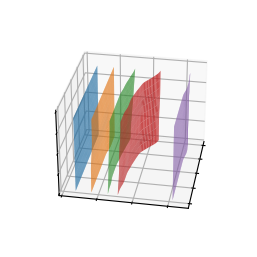

In [28]:
# Figure 1: visualize sheets in 3D
# --------------------------------
fig = plt.figure(figsize=(full_width * 0.38, full_width * 0.38))

ax = fig.add_subplot(111, projection='3d')

c_grid, c_index = np.unique(-c_rates, return_index=True)
c_index

cc_pred, ss_pred = np.meshgrid(c_grid, soc_grid)


for k in range(5):
    lt_k = np.log10(all_path_tau[k][c_index].T)
    
    # smooth tau values because tau are picked from a discrete grid
    lt_k = ndimage.gaussian_filter(lt_k, sigma=(2, 1))

    ax.plot_surface(-100 * ss_pred, lt_k, cc_pred, #facecolors=flat_colors, 
                    lw=1, antialiased=True, alpha=0.8,
                   rcount=100, ccount=100)
    

ax.set_ylim(-6, 1)

# Format ticks
soc_ticks = np.arange(50, 101, 12.5)
ax.set_xticks(-soc_ticks)
ax.set_xticklabels([50, '', 75, '', 100])
ax.set_yticklabels([-6, '', -4, '', -2, '', 0, ''])
ax.set_zticks(np.arange(0., 1.01, 0.25))
ax.set_zticklabels([0.0, '', 0.5, '', 1.0])

ax.invert_zaxis()

for axis in 'xyz':
    getattr(ax, f'set_{axis}ticklabels')([])


    
ax.view_init(azim=10, elev=30)

ff.savefig(fig, 'LIB_Map1_Sheets3D', transparent=True, ext='png')

## Refine sheet parameters with GP-ZARC model
Use the GP-ZARC model to parameterize and fit the DRT hypersurface. The sheet-tracing results are used to generate initial values for this step.

In [22]:
model = load_model('gp_marginal_ZARC_lnR_aniso')

In [29]:
# First, perform initial GP-ZARC fits of individual discharge cycles (2D in tau-SOC space) 
# using the sheet-tracing results for initialization.
# These 2D GP-ZARC results are then used to initialize the parameters for the full 
# 3D model below (tau-SOC-C_rate space).
# If the sheet-tracing results are used directly as initialization for the 3D model, 
# the optimization may fail to converge.
ss, cc = np.meshgrid(soc_grid, c_rates)

stan_results_2d = {}

# Filter sheet magnitude and time constant for cleaner initialization
ps_filt = ndimage.gaussian_filter(path_sizes, sigma=(0, 2, 2))
lt_filt = ndimage.gaussian_filter(np.log(path_tau), sigma=(0, 3, 2))

for c_index, key in enumerate(sorted_keys):
    cc_i = cc[c_index]
    ss_i = ss[c_index]
    
    print(key)
    print('C rate:', np.median(cc_i))
    
    # Transform SOC
    ss_i = stan_utils.transform_soc(ss_i, margin=0.05)
    
    # Get 2d R and tau estimates from sheets
    ps_i = ps_filt[:, c_index]
    lt_in = lt_filt[:, c_index]
    
    # Get 2d DRT
    y = f_stack[c_index, ..., :lf_index]
    R_scale_factor = 1 / np.std(y)
    y = y * R_scale_factor
    ps_i = ps_i * R_scale_factor
    
    # Log-scale resistance
    lnr = np.log(ps_i)

    # Construct input matrix - just SOC in 2d 
    X = ss_i.flatten()[:, None]
    # Normalize
    X /= np.std(X, axis=0)
    
    K = len(path_sizes)
    
    stan_data = {
        'N': len(X),
        'D': X.shape[1],
        'M': len(mrt_rbf.tau_supergrid[:lf_index]),
        'K': K,
        'tau': mrt_rbf.tau_supergrid[:lf_index],
        'x': X,
        'y': y,
        'sigma_gp_scale': 0.01,
        'sigma_rel_y_scale': 0.001,
        'sigma_rel_Rp_scale': 1,
        'R_sign': np.sign(np.median(ps_i, axis=1))
    }

    inits = {
        'lnR_mu': np.median(lnr, axis=1),
        'lntau_mu': np.median(lt_in, axis=1),
        'beta_trans_mu': np.ones(ps_i.shape[0]),
        'lnR_scale': 2 * np.std(lnr, axis=1) + 0.1,
        'lntau_scale': 2 * np.std(lt_in, axis=1) + 1e-1,
        'beta_trans_scale': np.ones(ps_i.shape[0]),
        'sigma_rel_y_raw': 1,
        'sigma_rel_Rp_raw': 1,
        'rho': np.ones((K, stan_data['D'])) * 10,
        'alpha': np.ones(K)
    }
    
    # Place floor on mean resistance to avoid convergence to zero
    inits['lnR_mu'] = np.maximum(inits['lnR_mu'], -3)
    
    # Initalize raw ZARC parameters
    inits['lnR_raw'] = (lnr - inits['lnR_mu'][:, None]) / inits['lnR_scale'][:, None]
    inits['lntau_raw'] = (lt_in - inits['lntau_mu'][:, None]) / inits['lntau_scale'][:, None]
    inits['beta_trans_raw'] = np.zeros(ps_i.shape)
    
    start = time.time()
    stan_mle = model.optimize(stan_data, iter=100, seed=24823, inits=inits, algorithm='lbfgs', init_alpha=1e-5)
    elapsed = time.time() - start
    print('Fit time: {:.1f} s'.format(elapsed))
    print('Converged:', stan_mle.converged)

    stan_results_2d[key] = {'mle': stan_mle, 'var': stan_mle.stan_variables(), 'R_scale': R_scale_factor}
    
R_stack_2d = np.stack([res['var']['R'] / res['R_scale'] for res in stan_results_2d.values()])
R_stack_2d = R_stack_2d.swapaxes(0, 1)

lt_stack_2d = np.stack([res['var']['lntau'] for res in stan_results_2d.values()])
lt_stack_2d = lt_stack_2d.swapaxes(0, 1)

beta_stack_2d = np.stack([res['var']['beta'] for res in stan_results_2d.values()])
beta_stack_2d = beta_stack_2d.swapaxes(0, 1)

y_stack_2d = np.stack([res['var']['y_hat'] / res['R_scale'] for res in stan_results_2d.values()])

13:15:44 - cmdstanpy - INFO - Chain [1] start processing


2_DISCHARGE
C rate: -0.1


13:15:47 - cmdstanpy - INFO - Chain [1] done processing


Fit time: 3.3 s
Converged: True
6_DISCHARGE
C rate: -0.1


13:15:47 - cmdstanpy - INFO - Chain [1] start processing
13:15:49 - cmdstanpy - INFO - Chain [1] done processing


Fit time: 2.4 s
Converged: True


13:15:50 - cmdstanpy - INFO - Chain [1] start processing


13_DISCHARGE
C rate: -0.2


13:15:53 - cmdstanpy - INFO - Chain [1] done processing


Fit time: 2.7 s
Converged: True


13:15:53 - cmdstanpy - INFO - Chain [1] start processing


5_DISCHARGE
C rate: -0.3


13:15:55 - cmdstanpy - INFO - Chain [1] done processing


Fit time: 2.3 s
Converged: True


13:15:56 - cmdstanpy - INFO - Chain [1] start processing


15_DISCHARGE
C rate: -0.3


13:15:58 - cmdstanpy - INFO - Chain [1] done processing


Fit time: 2.1 s
Converged: True


13:15:58 - cmdstanpy - INFO - Chain [1] start processing


11_DISCHARGE
C rate: -0.4


13:16:01 - cmdstanpy - INFO - Chain [1] done processing


Fit time: 2.6 s
Converged: True


13:16:01 - cmdstanpy - INFO - Chain [1] start processing


1_DISCHARGE
C rate: -0.5


13:16:04 - cmdstanpy - INFO - Chain [1] done processing


Fit time: 2.8 s
Converged: True


13:16:04 - cmdstanpy - INFO - Chain [1] start processing


7_DISCHARGE
C rate: -0.5


13:16:06 - cmdstanpy - INFO - Chain [1] done processing
13:16:06 - cmdstanpy - INFO - Chain [1] start processing


Fit time: 2.1 s
Converged: True
8_DISCHARGE
C rate: -0.6


13:16:08 - cmdstanpy - INFO - Chain [1] done processing


Fit time: 2.1 s
Converged: True


13:16:09 - cmdstanpy - INFO - Chain [1] start processing


4_DISCHARGE
C rate: -0.7


13:16:11 - cmdstanpy - INFO - Chain [1] done processing


Fit time: 2.1 s
Converged: True
14_DISCHARGE
C rate: -0.7


13:16:12 - cmdstanpy - INFO - Chain [1] start processing
13:16:14 - cmdstanpy - INFO - Chain [1] done processing


Fit time: 2.8 s
Converged: True


13:16:14 - cmdstanpy - INFO - Chain [1] start processing


10_DISCHARGE
C rate: -0.8


13:16:16 - cmdstanpy - INFO - Chain [1] done processing


Fit time: 1.8 s
Converged: True
12_DISCHARGE


13:16:16 - cmdstanpy - INFO - Chain [1] start processing


C rate: -0.9


13:16:18 - cmdstanpy - INFO - Chain [1] done processing


Fit time: 1.9 s
Converged: True
3_DISCHARGE
C rate: -1.0


13:16:18 - cmdstanpy - INFO - Chain [1] start processing
13:16:20 - cmdstanpy - INFO - Chain [1] done processing
13:16:21 - cmdstanpy - INFO - Chain [1] start processing


Fit time: 1.8 s
Converged: True
9_DISCHARGE
C rate: -1.0


13:16:23 - cmdstanpy - INFO - Chain [1] done processing


Fit time: 2.3 s
Converged: True


In [148]:
# Check scores
y_drt = f_stack[..., :lf_index]
r2_2d, fkl_2d = stan_utils.score_rq_gamma(mrt_rbf.tau_supergrid[:lf_index], y_drt, y_stack_2d)
r2_2d, np.mean(fkl_2d), np.min(fkl_2d)

(0.9933417357459937, 0.9808214015886358, 0.9407391026414382)

In [30]:
# 3d sheet optimization
# Initialize from 2D stan results
ss, cc = np.meshgrid(soc_grid, c_rates)

K = len(path_sizes)

# Get surface and scale    
y = f_stack[..., :lf_index].copy()
R_scale_factor = 1 / np.std(y)
y = y * R_scale_factor

ps_i = R_stack_2d * R_scale_factor
lnr = np.log(ps_i)

lt_in = lt_stack_2d.copy()

beta_in = beta_stack_2d.copy()
beta_trans_in = stan_utils.beta_transform(beta_in)

# Filter inputs
lnr = ndimage.gaussian_filter(lnr, sigma=(0, 1, 0.25))
lt_in = ndimage.gaussian_filter(lt_in, sigma=(0, 1, 0.25))
beta_trans_in = ndimage.gaussian_filter(beta_trans_in, sigma=(0, 1, 0.25))

# Reshape inputs
y = y.reshape((y.shape[0] * y.shape[1], y.shape[2]))
lnr = lnr.reshape((lnr.shape[0], np.prod(lnr.shape[1:])))
lt_in = lt_in.reshape(lnr.shape)
beta_trans_in = beta_trans_in.reshape(lnr.shape)

# Make data matrix
# Transform SOC
ss = stan_utils.transform_soc(ss, margin=0.05)
X = np.stack([ss.flatten(), cc.flatten(), test_stack.flatten()]).T
# Standardize variables 
X /= np.std(X, axis=0)


stan_data = {
    'N': len(X),
    'D': X.shape[1],
    'M': len(mrt_rbf.tau_supergrid[:lf_index]),
    'K': len(lnr),
    'tau': mrt_rbf.tau_supergrid[:lf_index],
    'x': X,
    'y': y,
    'sigma_gp_scale': 0.01,
    'sigma_rel_y_scale': 0.001,
    'sigma_rel_Rp_scale': 1,
    'R_sign': np.ones(len(lnr))
}

# ZARC
inits = {
    'lnR_mu': np.median(lnr, axis=1),
    'lntau_mu': np.median(lt_in, axis=1),
    'beta_trans_mu': np.median(beta_trans_in, axis=1),
    'lnR_scale': 2 * np.std(lnr, axis=1) + 0.1,
    'lntau_scale': 2 * np.std(lt_in, axis=1) + 1e-1,
    'beta_trans_scale': 2 * np.std(beta_trans_in, axis=1) + 1e-1,
    'sigma_rel_y_raw': 1,
    'sigma_rel_Rp_raw': 1,
    'rho': np.ones((K, stan_data['D'])),
    'alpha': np.ones(K)
}

# Set initial length scales
inits['rho'][:, 0] = 0.25  # SOC
inits['rho'][:, 1] = 1  # C rate
inits['rho'][:, 2] = 1. # 0.5 # Cycle number

# Set raw parameter values
inits['lnR_raw'] = (lnr - inits['lnR_mu'][:, None]) / inits['lnR_scale'][:, None]
inits['lntau_raw'] = (lt_in - inits['lntau_mu'][:, None]) / inits['lntau_scale'][:, None]
inits['beta_trans_raw'] = (beta_trans_in - inits['beta_trans_mu'][:, None]) / inits['beta_trans_scale'][:, None]

try:
    # Load previous fit results 
    # Comment this out or change the filename if you want to run the Stan model yourself
    stan_results = load_pickle(fit_path.joinpath('stan_results.pkl'))
except FileNotFoundError:
    start_time = time.time()
    stan_mle = model.optimize(stan_data, iter=100, seed=24823, inits=inits, algorithm='lbfgs', init_alpha=1e-5)
    elapsed = time.time() - start_time
    print('Fit time: {:.1f} s'.format(elapsed))
    print('Converged:', stan_mle.converged)
    stan_results = {
        'mle': stan_mle, 
        'var': stan_mle.stan_variables(), 
        'R_scale': R_scale_factor,
        'orig_shape': path_sizes.shape}
    
    save_pickle(stan_results, fit_path.joinpath('stan_results.pkl'))

# Reshape stan output
R_stack = stan_results['var']['R'].reshape(stan_results['orig_shape']) / stan_results['R_scale'] 
lt_stack = stan_results['var']['lntau'].reshape(stan_results['orig_shape'])
beta_stack = stan_results['var']['beta'].reshape(stan_results['orig_shape'])
Rgp_stack = stan_results['var']['R_gp'].reshape(stan_results['orig_shape']) / stan_results['R_scale'] 
y_stack = stan_results['var']['y_hat'].reshape(f_stack[..., :lf_index].shape) / stan_results['R_scale'] 

13:16:27 - cmdstanpy - INFO - Chain [1] start processing
13:20:10 - cmdstanpy - INFO - Chain [1] done processing


Fit time: 223.7 s
Converged: True


In [33]:
# Check scores
y_drt = f_stack[..., :lf_index]
y_stack = stan_results['var']['y_hat'].reshape(f_stack[..., :lf_index].shape) / stan_results['R_scale'] 
r2_full, fkl_full = stan_utils.score_rq_gamma(mrt_rbf.tau_supergrid[:lf_index], y_drt, y_stack)
np.mean(fkl_full), np.min(fkl_full), np.min(fkl_2d)

(0.978625533698612, 0.9463348416117893, 0.9407391026414382)

<IPython.core.display.Javascript object>


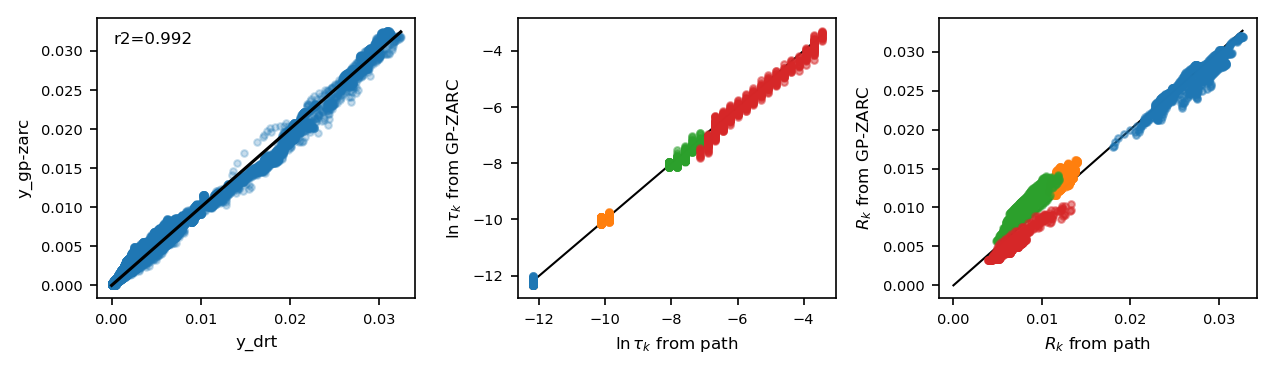

In [89]:
# Check optimized result
y_drt = f_stack[..., :lf_index]
y_stack = stan_results['var']['y_hat'].reshape(y_drt.shape) / stan_results['R_scale'] 

fig, axes = plt.subplots(1, 3, figsize=(8.5, 2.5))

# DRT surface vs. GP-ZARC surface
axes[0].scatter(y_drt, y_stack, s=10, alpha=0.25)
y_plot = [np.min(y_drt), np.max(y_drt)]
axes[0].plot(y_plot, y_plot, c='k', zorder=10)

r2 = r2_score(y_drt.flatten(), y_stack.flatten())
axes[0].text(0.05, 0.95, 'r2={:.3f}'.format(r2), transform=axes[0].transAxes, ha='left', va='top')

axes[0].set_xlabel('y_drt')
axes[0].set_ylabel('y_gp-zarc')

# Optimized ZARC params vs. params estimated from sheet tracing
for k in range(R_stack.shape[0]):
    axes[1].scatter(np.log(path_tau[k]).flatten(), lt_stack[k].flatten(), s=10, alpha=0.5)
    axes[2].scatter(path_sizes[k].flatten(), R_stack[k].flatten(), s=10, alpha=0.5)
    
lt_plot = [np.min(np.log(path_tau)), np.max(np.log(path_tau))]
axes[1].plot(lt_plot, lt_plot, c='k', lw=1, zorder=-10)
axes[2].plot([0, np.max(path_sizes)], [0, np.max(path_sizes)], c='k', lw=1, zorder=-10)

axes[1].set_xlabel(r'$\ln{\tau_k}$ from path')
axes[1].set_ylabel(r'$\ln{\tau_k}$ from GP-ZARC')

axes[2].set_xlabel('$R_k$ from path')
axes[2].set_ylabel('$R_k$ from GP-ZARC')


fig.tight_layout()

### Conceptual LIB mapping figure
Make subplots for Figure 2 of the main text showing the flow of the mapping procedure.

2 -0.1
2 -0.1
3 -1.0


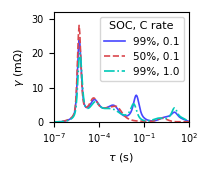

In [221]:
# Show 1d DRTs at different points in the SOC-C_rate space
# --------------------------------------------------------
fs = (full_width * 0.31, full_width * 0.26)
mini_fs = (full_width * 0.3, full_width * 0.25)

drt_1d_fig, drt_1d_ax = plt.subplots(figsize=(fs))


c_indices = [0, 0, 13]
soc_indices = [49, 0, 49]
ls_list = ['-', '--', '-.']

# Plot 1d DRTs
tau_plot = np.logspace(-7, 3, 201)

for ii, i in enumerate(soc_indices):
    c_index = c_indices[ii]
    test_id = test_id_list[c_index]
    print(test_id, c_rates[c_index])
    key = f'{test_id}_DISCHARGE'
    x_raw = struct_results[key]['x_raw']
    x_filt = struct_results[key]['x_filt']
    x_dop = struct_results[key]['x_dop_filt']
    x_inf = struct_results[key]['R_inf_filt']
    p_ridge = struct_results[key]['rp_raw']
    
    gamma = mrt_rbf.predict_drt(psi=None, x=x_filt, tau=tau_plot)

    drt_1d_ax.plot(tau_plot, gamma[i] * 1000, lw=1.2, c=light_colors[ii], 
                   label='{}%, {}'.format(int(soc_grid[i] * 100), -c_rates[c_index]),
                  ls=ls_list[ii])
    
drt_1d_ax.set_xscale('log')
drt_1d_ax.set_xlim(1e-7, 1e2)
drt_1d_ax.set_ylim(0, 32)
drt_1d_ax.set_xlabel(r'$\tau$ (s)')
drt_1d_ax.set_ylabel(r'$\gamma$ (m$\Omega$)')
drt_1d_ax.legend(title='SOC, C rate', fontsize=7.5)

drt_1d_fig.tight_layout()
ff.savefig(drt_1d_fig, 'LIB_Map1_Drt1d', transparent=True, ext='png')

test 6 C rate: -0.1
test 11 C rate: -0.4
test 14 C rate: -0.7
test 9 C rate: -1.0


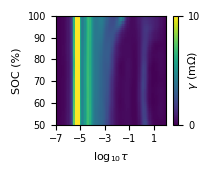

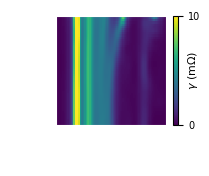

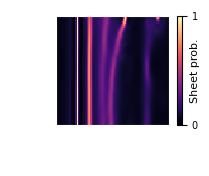

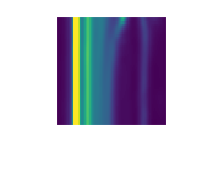

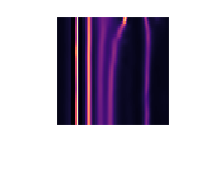

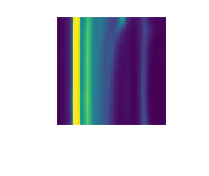

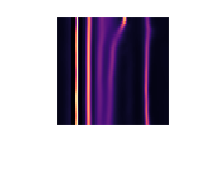

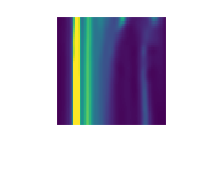

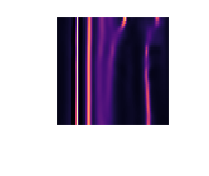

In [223]:
# Plot 2D DRT and ridge prob surfaces
# -----------------------------------
drt_2d_fig, drt_2d_ax = plt.subplots(figsize=(fs))
test_id = 4
stack_index = test_id_list.index(test_id)

key = f'{test_id}_DISCHARGE'
x_raw = struct_results[key]['x_raw']
x_filt = struct_results[key]['x_filt']
x_dop = struct_results[key]['x_dop_filt']
x_inf = struct_results[key]['R_inf_filt']
p_ridge = struct_results[key]['rp_raw']
# gamma_raw = mrt_rbf.predict_drt(psi=None, x=x_raw)
# gamma_filt = mrt_rbf.predict_drt(psi=None, x=x_filt)

# Plot exemplary 2D DRT
drt_lim = (0, 0.01)
sm_drt, _ = plot_drt_2d(x_filt, soc_grid, mrt_rbf, ax=drt_2d_ax, cmap='viridis', vmin=drt_lim[0], vmax=drt_lim[1])
cb_drt = drt_2d_fig.colorbar(sm_drt, ax=drt_2d_ax)
cb_drt.set_ticks(list(drt_lim))
cb_drt.set_ticklabels((np.array(list(drt_lim)) * 1000).astype(int))
cb_drt.set_label('$\gamma$ (m$\Omega$)', labelpad=-10)
drt_2d_fig.tight_layout()
ff.savefig(drt_2d_fig, 'LIB_Map1_Drt2d', transparent=True, ext='png')

# Plot 2D DRTs and sheet probability for C-rate stack

for i, test_id in enumerate([6, 11, 14, 9]):
    print('test {} C rate: {}'.format(test_id, c_rates[test_id_list.index(test_id)]))
    key = f'{test_id}_DISCHARGE'
    x_raw = struct_results[key]['x_raw']
    x_filt = struct_results[key]['x_filt']
    x_dop = struct_results[key]['x_dop_filt']
    x_inf = struct_results[key]['R_inf_filt']
    p_ridge = struct_results[key]['rp_raw']
    
    drt_stack_fig, drt_stack_ax = plt.subplots(figsize=fs)
    
    sm_drt, _ = plot_drt_2d(x_filt, soc_grid, mrt_rbf, ax=drt_stack_ax, cmap='viridis', 
                            vmin=drt_lim[0], vmax=drt_lim[1])
    if i == 0:
        cb_drt = drt_stack_fig.colorbar(sm_drt, ax=drt_stack_ax)
        cb_drt.set_ticks(list(drt_lim))
        cb_drt.set_ticklabels((np.array(list(drt_lim)) * 1000).astype(int))
        cb_drt.set_label('$\gamma$ (m$\Omega$)', labelpad=-10)
    
        drt_stack_fig.tight_layout()
        drt_bbox = drt_stack_ax.get_position()
#     drt_stack_fig.subplots_adjust(left=0.05, right=0.75, bottom=0.05, top=0.95)
    else:
        drt_stack_ax.set_position(drt_bbox)
        
    drt_stack_ax.set_xticks([])
    drt_stack_ax.set_yticks([])
    drt_stack_ax.set_xlabel('')
    drt_stack_ax.set_ylabel('')
    
    for spine in drt_stack_ax.spines.values():
        spine.set_edgecolor('white')
    
    ff.savefig(drt_stack_fig, f'LIB_Map1_Drt2dStack{i}', transparent=True, ext='png')
        
    
    
    prob_stack_fig, prob_stack_ax = plt.subplots(figsize=fs)
        
    sm_rp, _ = plot_x_2d(p_ridge, soc_grid, mrt_rbf, ax=prob_stack_ax, vmin=0, vmax=1, cmap='magma')
    if i == 0:
        cb_rp = prob_stack_fig.colorbar(sm_rp, ax=prob_stack_ax)
        cb_rp.set_ticks([0, 1])
        cb_rp.set_label('Sheet prob.', labelpad=-6)
        
        prob_stack_fig.tight_layout()
        prob_bbox = prob_stack_ax.get_position()
    else:
        prob_stack_ax.set_position(prob_bbox)
        
    prob_stack_ax.set_xticks([])
    prob_stack_ax.set_yticks([])
    prob_stack_ax.set_xlabel('')
    prob_stack_ax.set_ylabel('')
    
    for spine in prob_stack_ax.spines.values():
        spine.set_edgecolor('white')
    
    ff.savefig(prob_stack_fig, f'LIB_Map1_Prob2dStack{i}', transparent=True, ext='png')

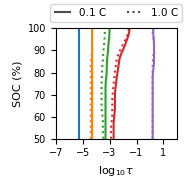

In [218]:
# Show 2d slices of sheets at different C rates
# ---------------------------------------------
path_fig, path_ax = plt.subplots(figsize=(fs[0] * 0.9, fs[1] * 1.08))


ltf = ndimage.gaussian_filter(np.log10(all_path_tau), sigma=(0, 1, 2))

# Plot ghost mesh for 2d formatting
plot_x_2d(p_ridge, soc_grid, mrt_rbf, ax=path_ax, vmin=0, vmax=1, cmap='magma', alpha=0)

for stack_index, ls in zip([0, -1], ['-', ':']):
    for k in range(5):
    #     lt_k = all_path_tau[k, stack_index]
    #     path_ax.plot(np.log10(np.exp(lt_k)), soc_grid, label=f'P{k + 1}')
        lt_k = ltf[k, stack_index]
#         t_k = ndimage.gaussian_filter1d(t_k, axis=-1, sigma=3)
        path_ax.plot(lt_k, soc_grid, color=default_colors[k], ls=ls)
    
path_ax.plot([10, 10,], [0.7, 0.7], c='k', ls='-', label='0.1 C', alpha=0.7)
path_ax.plot([10, 10,], [0.7, 0.7], c='k', ls=':', label='1.0 C', alpha=0.7)
    
    
path_ax.set_xlim(-7, 2)
# path_ax.legend(handlelength=1., fontsize=7.5, title='C rate', bbox_to_anchor=(0.85, 1), loc='upper left')
path_fig.tight_layout()
path_ax.legend(handlelength=1.5, fontsize=7.5, ncol=2, bbox_to_anchor=(0.5, 1.27), loc='upper center')
path_fig.subplots_adjust(top=0.85)

ff.savefig(path_fig, 'LIB_Map1_Sheets2d', ext='png')

### GP-ZARC deconvolution
Figure 3 of the main text showing how the GP-ZARC model deconvolutes the DRT hypersurface.

C rate: -0.7


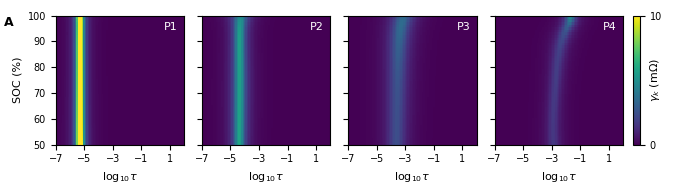

In [217]:
# Show GP-ZARC deconvolution of DRT hypersurface
# ----------------------------------------------
fig, axes = plt.subplots(1, 4, figsize=(full_width, full_width * 0.29), sharex=True, sharey=False)

test_id = 4
stack_index = test_id_list.index(test_id)
print('C rate:', c_rates[stack_index])

f_rq = hybdrt.models.elements.element_distribution_function('RQ')
rq_dist = np.array([f_rq(t, R_stack, lt_stack, beta_stack) for t in mrt_rbf.tau_supergrid])
rq_dist = np.moveaxis(rq_dist, 0, -1)
rq_drt = np.sum(rq_dist, axis=0)

for k, ax in enumerate(axes):
    sm_drt, _ = plot_x_2d(rq_dist[k, stack_index], soc_grid, mrt_rbf, ax=ax, cmap='viridis',
                      vmin=0, vmax=0.01
             )
    
    ax.text(0.95, 0.95, f'P{k + 1}', transform=ax.transAxes, ha='right', va='top', color='white')
    
for ax in axes[1:]:
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
    
fig.tight_layout()

fig.subplots_adjust(right=0.92)

bbox = axes[-1].get_position()
cax = fig.add_axes([bbox.x1 + 0.015, bbox.y0, 0.01, bbox.height])

drt_lim = (0, 0.01)
cb_drt = fig.colorbar(sm_drt, cax=cax)
cb_drt.set_ticks(list(drt_lim))
cb_drt.set_ticklabels((np.array(list(drt_lim)) * 1000).astype(int))
cb_drt.set_label('$\gamma_k$ (m$\Omega$)', labelpad=-10)

ff.add_letters(axes[:1], loc=[(-0.4, 1)]) #+ [(-0.2, 1)] * 3)

ff.savefig(fig, 'LIB_MapFig2_Top', ext='png')

### Partial dependence analysis
Train GP models directly on the ZARC parameters extracted from the Stan GP-ZARC model. These direct GPs are used for partial dependence analysis.

In [50]:
# Train GPs on stan results
ss, cc = np.meshgrid(soc_grid, c_rates)

X_train = np.stack([ss.flatten(), -cc.flatten(), test_stack.flatten()])
X_train = X_train.T

# NOTE: variable normalization is handled in gps_from_stan with a sklearn Pipeline
stan_gps = stan_utils.gps_from_stan(stan_data, stan_results, X_train, extract_kernel=False, noise_level=1e-3)

# Check kernels
print('ZARC kernels')
for i, gpi in enumerate(stan_gps['R']):
    print(i + 1, gpi['gp'].reg.kernel_)
    


c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


ZARC kernels
1 RBF(length_scale=[3.95, 0.01, 0.01]) + WhiteKernel(noise_level=0.001)
2 RBF(length_scale=[2.01, 0.572, 20]) + WhiteKernel(noise_level=0.001)
3 RBF(length_scale=[3.51, 1.71, 0.918]) + WhiteKernel(noise_level=0.001)
4 RBF(length_scale=[2, 3.63, 1.36]) + WhiteKernel(noise_level=0.001)


In [ ]:
# Make GPs for R_inf and transport process
soc_transformer = stan_utils.SOCTransform(margin=0.05, soc_index=0)
scaler = StandardScaler()
kernel_gen = 1.0 * kernels.RBF(length_scale=(1, 1, 0.5), length_scale_bounds=(0.1, 100))
kernel_inf = kernel_gen + kernels.WhiteKernel(noise_level=0.5, noise_level_bounds='fixed')
kernel_transport = kernel_gen + kernels.WhiteKernel(noise_level=0.75, noise_level_bounds='fixed')

raw_gps = {}
print('Raw kernels')
for name, kernel in zip(['R_inf', 'R_trans'], [kernel_inf, kernel_transport]):
    gp_ = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gp = Pipeline([('trans', soc_transformer), ('scale', scaler), ('gp', gp_)])
    if name == 'R_inf':
        R_inf_train = R_inf_stack.flatten()
        gp.fit(X_train, R_inf_train)
    else:
        R_trans_train = R_trans_stack.flatten()
        gp.fit(X_train, R_trans_train)
    raw_gps[name] = gp
    print(name, gp['gp'].kernel_)

In [52]:
# Get partial dependence results
# stan_pdps: P1-P4 from GP-ZARC model
stan_pdps = {}

for name in stan_gps.keys():
    pdp_list = []
    for k in range(len(stan_gps[name])):
        pdp_k = partial_dependence(stan_gps[name][k], X_train, [0, 1],
                           percentiles=(0.001, 0.99), 
                           grid_resolution=20, method='auto')
        pdp_list.append(pdp_k)

    stan_pdps[name] = pdp_list

In [39]:
# raw_gps: R_inf and R_LF from direct quantification
raw_pdps = {}
for name in list(raw_gps.keys()):
    pdp = partial_dependence(raw_gps[name], X_train, [0, 1],
                               percentiles=(0.001, 0.99), 
                               grid_resolution=20, method='auto', kind='average')
    raw_pdps[name] = pdp

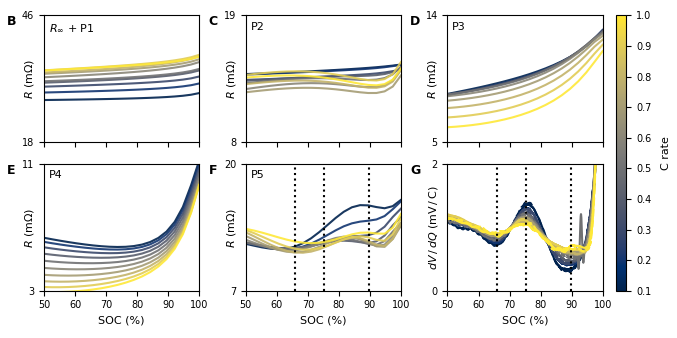

In [54]:
# Partial dependence plots: C_rate-SOC interaction for individual processes
# -------------------------------------------------------------------------
# capacity values corresponding to phase transitions/equilibria
trans_cap = [3050, 2560, 2240]

fig, axes = plt.subplots(2, 3, figsize=(full_width, full_width * 0.5), sharex=True)

v1, v2 = stan_pdps['R'][0]['values']
xx, yy = np.meshgrid(v2, v1)


scatter_kw = dict(s=10, alpha=0.5)

for k in range(5):
    ax = axes.ravel()[k]
    
    if k == 0:
        z_k = raw_pdps['R_inf']['average'][0] + stan_pdps['R'][k]['average'][0]
    elif k < 4:
        z_k = stan_pdps['R'][k]['average'][0]
    else:
        z_k = raw_pdps['R_trans']['average'][0]
        
    for i in range(z_k.shape[1]):
        ax.plot(v1 * 100, 1000 * z_k[:, i], color=c_cmap(c_norm(v2[i])), alpha=0.9)

    # Se y range to 75% of max
    z_max = np.max(1000 * z_k)
    z_range = z_max * 0.75
    
    y0, y1 = ax.get_ylim()
    y_cent = 0.5 * (y0 + y1)
    y0 = round(y_cent - z_range / 2, 0)
    y1 = round(y_cent + z_range / 2, 0)
    
    ax.set_ylim(y0, y1)
    ax.set_yticks([y0, y1])
    
    ax.set_ylabel(f'$R$ (m$\Omega$)', labelpad=-10)
   

for k in range(5):
    ax = axes.ravel()[k]
    if k == 0:
        ax.text(0.03, 0.95, f'$R_\infty$ + P{k + 1}', transform=ax.transAxes, ha='left', va='top')
    else:
        ax.text(0.03, 0.95, f'P{k + 1}', transform=ax.transAxes, ha='left', va='top')

# Plot differential discharge curves
for c_rate in np.arange(0.1, 1.01, 0.1):
    keys = [k for k, v in discharge_data.items() if v['c_rate'] == round(c_rate, 1)]

    for i, key in enumerate(keys):
        if i > 0:
            ls = '--'
        else:
            ls = '-'

        # Use model data for differential curve
        times, i_sig, v_sig = discharge_data[key]['pred_tup']
        plot_cap = discharge_data[key]['pred_cap_delta']
        plot_soc = (1 + plot_cap / tot_cap) * 100

        axes[1, 2].plot(plot_soc[11:], np.abs(np.diff(v_sig) / np.diff(plot_cap))[10:] * 3600, 
                label='{}C (Cycle {})'.format(discharge_data[key]['c_rate'], key), 
                ls=ls, color=c_cmap(c_norm(c_rate)))
        
axes[1, 2].set_ylim(0, 2)
axes[1, 2].set_yticks([0, 2])
axes[1, 2].set_ylabel('$dV \, / \, dQ$ (mV$\,$/$\,$C)', labelpad=-6)

for ax in axes[1]:
    ax.set_xlabel('SOC (%)')
    
for ax in axes[1, 1:]:
    for v in trans_cap:
        ax.axvline(100 * v / tot_cap, c='k', ls=':')
        
axes[0, 0].set_xlim(50, 100)
    
fig.tight_layout()

fig.subplots_adjust(left=0.065, right=0.89, wspace=0.3)
sm = mpl.cm.ScalarMappable(cmap=c_cmap, norm=c_norm)
bbox1 = axes[0, 2].get_position()
bbox2 = axes[1, 2].get_position()
cax = fig.add_axes([bbox1.x1 + 0.02, bbox2.y0, 0.015, bbox1.y1 - bbox2.y0])
cb = fig.colorbar(sm, cax=cax)
# cb.set_ticks([0.1, 1])
cb.set_label('C rate', labelpad=7)

ff.add_letters(axes, loc=(-0.24, 1.0), start_index=1)
ff.savefig(fig, 'LIB_MapFig2_Bottom', ext='png')

In [ ]:
# Count total number of spectra
num_obs = 0
for test_id in np.arange(1, 16):
    key = f'{test_id}_DISCHARGE'
    index = mrt_rbf.get_group_index(key)
    num_obs += min(len(soc_grid), len(index))
    
num_obs

752

## Supplemental figures

### Cycle number partial dependence

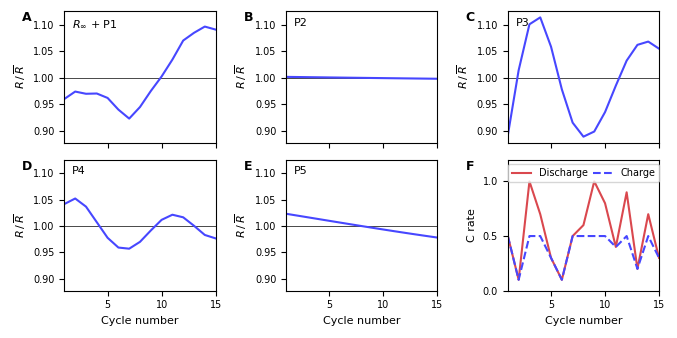

In [56]:
fig, axes = plt.subplots(2, 3, figsize=(full_width, full_width * 0.5), sharex=True)

# 1d partial dependence on cycle number
pdp_inf_cyc = partial_dependence(raw_gps['R_inf'], X_train, 2,
                           grid_resolution=20, method='auto', kind='both')
pdp_trans_cyc = partial_dependence(raw_gps['R_trans'], X_train, 2,
                           grid_resolution=20, method='auto', kind='both')

cycle_pdp_list = []
for k in range(len(stan_gps['R'])):
    pdp_c = partial_dependence(stan_gps['R'][k], X_train, 2,
                           grid_resolution=20, method='auto', kind='both')
    cycle_pdp_list.append(pdp_c)


axes[0, 0].get_shared_y_axes().join(*axes.ravel()[:5])

for k in range(5):
    ax = axes.ravel()[k]
    if k < 4:
        y_k = cycle_pdp_list[k]['average'][0]
    else:
        y_k = pdp_trans_cyc['average'][0]
        
    if k == 0:
        # Add R_inf to P1
        y_k = y_k + pdp_inf_cyc['average'][0]
        
    ax.plot(pdp_c['values'][0], y_k / np.mean(y_k), c=light_colors[0])
    ax.axhline(1, c='k', lw=0.5, zorder=-10)
    ax.set_ylabel('$R \, / \, \overline{R}$')
    
    if k == 0:
        ax.text(0.05, 0.95, f'$R_\infty$ + P{k + 1}', ha='left', va='top', transform=ax.transAxes)
    else:
        ax.text(0.05, 0.95, f'P{k + 1}', ha='left', va='top', transform=ax.transAxes)


# Plot discharge/charge rates
discharge_rates = [v['discharge']['c_rate'] for v in test_data.values()]
charge_rates = [v['charge']['c_rate'] for v in test_data.values()]

axes[1, 2].plot(np.arange(1, 16), discharge_rates, label='Discharge', c=light_colors[1])
axes[1, 2].plot(np.arange(1, 16), charge_rates, label='Charge', c=light_colors[0], ls='--')
axes[1, 2].legend(ncol=2, columnspacing=0.5, loc='upper center', fontsize=7)
axes[1, 2].set_ylabel('C rate')
axes[1, 2].set_ylim(0., 1.2)
axes[1, 2].set_yticks([0.0, 0.5, 1.0])

axes[0, 0].set_xlim(1, 15)
for ax in axes[1]:
    ax.set_xlabel('Cycle number')

fig.tight_layout()

ff.add_letters(axes, loc=(-0.28, 1))
ff.savefig(fig, 'Supp_LIB_CyclePDP')

### Parameter refinement and filtering

C rate: 0.1


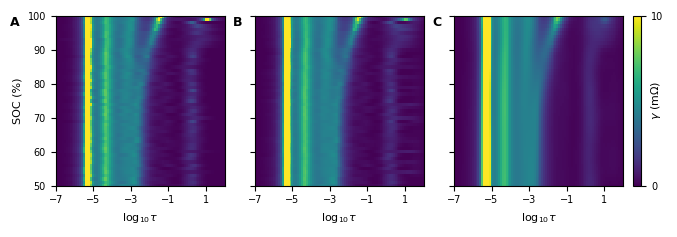

In [210]:
test_id = 2
print('C rate:', discharge_data[test_id]['c_rate'])

fig, axes = plt.subplots(1, 3, figsize=(full_width, full_width * 0.35), sharex=True, sharey=True)

res = struct_results[f'{test_id}_DISCHARGE']

for i, stage in enumerate(['raw', 'res', 'filt']):
    x = res[f'x_{stage}']
    sm, _ = plot_drt_2d(1000 * x, soc_grid, mrt_rbf, ax=axes[i], vmin=0, vmax=10)
    
fig.tight_layout()

# add colorbar
fig.subplots_adjust(right=0.92)
bbox = axes[2].get_position()
cax = fig.add_axes([bbox.x1 + 0.015, bbox.y0, 0.012, bbox.height])
cb = fig.colorbar(sm, cax=cax)
cb.set_ticks([0, 10])
cb.set_label(r'$\gamma$ (m$\Omega$)', labelpad=-10)

for ax in axes[1:]:
    ax.set_ylabel('')

loci = [(-0.27, 1)] + [(-0.13, 1)] * 2
ff.add_letters(axes, loc=loci)

ff.savefig(fig, 'Supp_LIB_RefineFilterExample', ext='png')

### 1d sheet probability illustration

SOC: 0.7


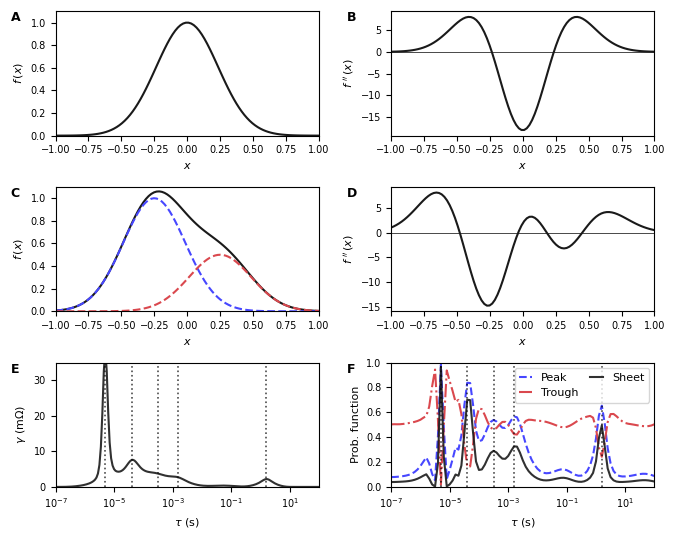

In [215]:
fig, axes = plt.subplots(3, 2, figsize=(full_width, full_width * 0.8), sharex=False)

axes[0, 0].get_shared_x_axes().join(*axes[:2].ravel())

# RBF illustration of premise
f0 = hybdrt.matrices.basis.get_basis_func('gaussian')
f1 = hybdrt.matrices.basis.get_basis_func_derivative('gaussian', order=1)
f2 = hybdrt.matrices.basis.get_basis_func_derivative('gaussian', order=2)
funcs = [f0, f1, f2]

rbf_params1 = [(1, 0, 3)]
rbf_params2 = [(1, -0.25, 3), (0.5, 0.25, 3)]

x = np.linspace(-1, 1, 100)

for i, rbf_params in enumerate([rbf_params1, rbf_params2]):
    rbf_vals = []
    tot_vals = []
    for j in range(3):
        func = funcs[j]
        rbf_vals.append(np.array([p[0] * func(x - p[1], p[2]) for p in rbf_params]))
        tot_vals.append(np.sum(rbf_vals[j], axis=0))

    rbf_vals = np.stack(rbf_vals)
    
    axes[i, 0].plot(x, tot_vals[0], c=data_kw['edgecolors'])
    if len(rbf_params) > 1:
        for j in range(rbf_vals.shape[1]):
            axes[i, 0].plot(x, rbf_vals[0, j], c=light_colors[j], ls='--')
#             axes[i, 0].axvline(rbf_params[j][1], ls='--')
#             axes[i, 1].axvline(rbf_params[j][1], ls='--')

    axes[i, 1].plot(x, tot_vals[2], c=data_kw['edgecolors'])
    
for ax in axes[:2].ravel():
    ax.set_xlim(-1, 1)
    
for ax in axes[:2].ravel():
    ax.set_xlabel('$x$')
    
for ax in axes[:2, 0]:
    ax.set_ylim(0, 1.1)
    ax.set_ylabel('$f\,(x)$')
    
for ax in axes[:2, 1]:
    ax.axhline(0, c='k', lw=0.5, zorder=-10)
    ax.set_ylabel('$f^{\ \prime\prime}\,(x)$')
    

# Real data - Ridge/peak prob in 1d
test_id = 4
key = f'{test_id}_DISCHARGE'
# print('C rate:', discharge_data[test_id]['c_rate'])
res = struct_results[key]
x = res['x_raw'].copy()
cp = res['peak_prob_only']
tp = res['trough_prob_only']
rp = res['rp_raw']
tau_plot = mrt_rbf.get_tau_eval(20)
gamma = mrt_rbf.predict_drt(psi=None, x=x, order=0, tau=tau_plot)

s_index = 20
print('SOC:', soc_grid[s_index])
drt_color = light_colors[0]
axes[2, 0].plot(tau_plot, 1000 * gamma[s_index], c=data_kw['edgecolors'], alpha=0.9)


axes[2, 1].plot(mrt_rbf.tau_supergrid, cp[s_index], c=light_colors[0], ls='--', label='Peak')
axes[2, 1].plot(mrt_rbf.tau_supergrid, tp[s_index], c=light_colors[1], ls='-.', label='Trough')
axes[2, 1].plot(mrt_rbf.tau_supergrid, rp[s_index], c=data_kw['edgecolors'], alpha=0.9, label='Sheet')

# Find peaks in rp
peaks, _ = find_peaks(rp[s_index], height=0.2)

for peak in peaks:
    for ax in axes[2]:
        ax.axvline(mrt_rbf.tau_supergrid[peak], c='k', ls=':', alpha=0.7, lw=1.2)
    
for ax in axes[2]:
    ax.set_xscale('log')
    ax.set_xlabel(r'$\tau$ (s)')
    ax.set_xlim(1e-7, 1e2)
    
axes[2, 0].set_ylim(0, 35)
axes[2, 1].set_ylim(0, 1)

axes[2, 0].set_ylabel(r'$\gamma$ (m$\Omega$)')
axes[2, 1].set_ylabel(r'Prob. function')
axes[2, 1].legend(ncol=2, columnspacing=1, handlelength=1.2)
    
fig.tight_layout()

ff.add_letters(axes, loc=(-0.17, 1))
ff.savefig(fig, 'Supp_LIB_SheetProb1dExample', ext='png')

### Exhaustive 2D DRT and DOP surfaces

In [12]:
test_rate_dict = {k: v['c_rate'] for k, v in discharge_data.items()}

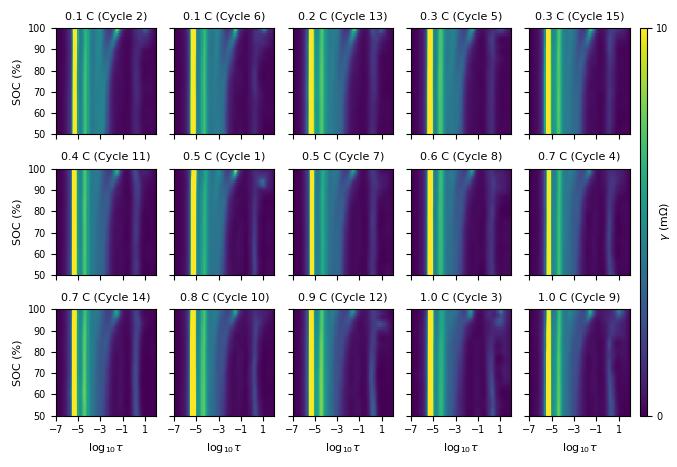

In [15]:
# DRT surfaces
# Sort by C rate first, test_id second

get_sort_val = lambda x: test_rate_dict[x] * 100 + x * 0.1
test_id_sort = sorted(list(np.arange(1, 16)), key=get_sort_val)

fig, axes = plt.subplots(3, 5, figsize=(full_width, full_width * 0.69), sharex=True, sharey=True)

for i, test_id in enumerate(test_id_sort):
    ax = axes.ravel()[i]
    x = struct_results[f'{test_id}_DISCHARGE']['x_filt']
    gamma = mrt_rbf.predict_drt(x=x)
    
    sm, _ = plot_drt_2d(1000 * x, soc_grid, mrt_rbf, ax=ax, vmin=0, vmax=10)
    ax.set_title('{:.1f} C (Cycle {})'.format(test_rate_dict[test_id], test_id), fontsize=8)
    
for ax in axes[:, 1:].ravel():
    ax.set_ylabel('')
#     ax.set_yti

for ax in axes[:-1].ravel():
    ax.set_xlabel('')
    
fig.tight_layout()

fig.subplots_adjust(right=0.93)
bbox1 = axes[0, 4].get_position()
bbox2 = axes[2, 4].get_position()
cax = fig.add_axes([bbox1.x1 + 0.015, bbox2.y0, 0.01, bbox1.y1 - bbox2.y0])
cb = fig.colorbar(sm, cax=cax)
cb.set_ticks([0, 10])
cb.set_label(r'$\gamma$ (m$\Omega$)', labelpad=-8)

ff.savefig(fig, 'Supp_LIB_DrtSurfaces2d')

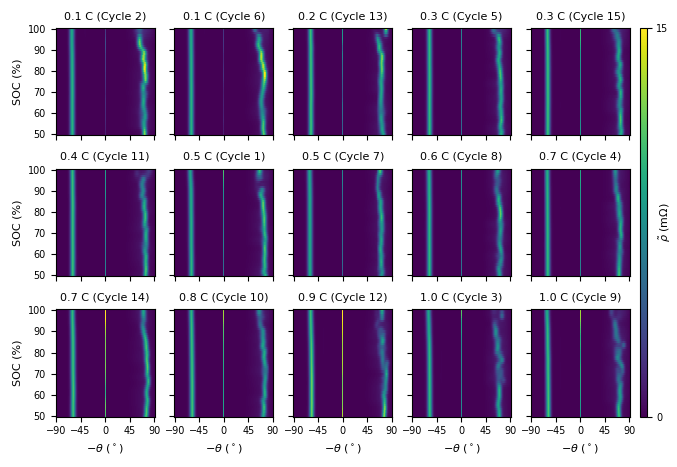

In [14]:
# DOP surfaces
# Sort by C rate first, test_id second
get_sort_val = lambda x: test_rate_dict[x] * 100 + x * 0.1
test_id_sort = sorted(list(np.arange(1, 16)), key=get_sort_val)

fig, axes = plt.subplots(3, 5, figsize=(full_width, full_width * 0.69), sharex=True, sharey=True)

vmax = 15
# vmax = 30

for i, test_id in enumerate(test_id_sort):
    ax = axes.ravel()[i]
    x = struct_results[f'{test_id}_DISCHARGE']['x_dop_filt']
    x_inf = struct_results[f'{test_id}_DISCHARGE']['R_inf_filt']
    # print('max R_inf:', 1000 * np.max(x_inf))
    
    sm, _ = plot_dop_2d(1000 * x, soc_grid, mrt_rbf, ax=ax, normalize=True, 
                        normalize_tau=norm_tau,
                        include_ohmic=True, x_ohmic=x_inf * 1000,
                        nu_grid=np.linspace(-1, 1, 101),
                        vmin=0, vmax=vmax)
    ax.set_title('{:.1f} C (Cycle {})'.format(test_rate_dict[test_id], test_id), fontsize=8)
    
for ax in axes[:, 1:].ravel():
    ax.set_ylabel('')
#     ax.set_yti

for ax in axes[:-1].ravel():
    ax.set_xlabel('')
    
fig.tight_layout()

fig.subplots_adjust(right=0.93, wspace=0.2)
bbox1 = axes[0, 4].get_position()
bbox2 = axes[2, 4].get_position()
cax = fig.add_axes([bbox1.x1 + 0.015, bbox2.y0, 0.01, bbox1.y1 - bbox2.y0])
cb = fig.colorbar(sm, cax=cax)
cb.set_ticks([0, vmax])
cb.set_label(r'$\tilde{\rho}$ (m$\Omega$)', labelpad=-8)

ff.savefig(fig, 'Supp_LIB_DopSurfaces2d')

### Exhaustive sheet probability surfaces

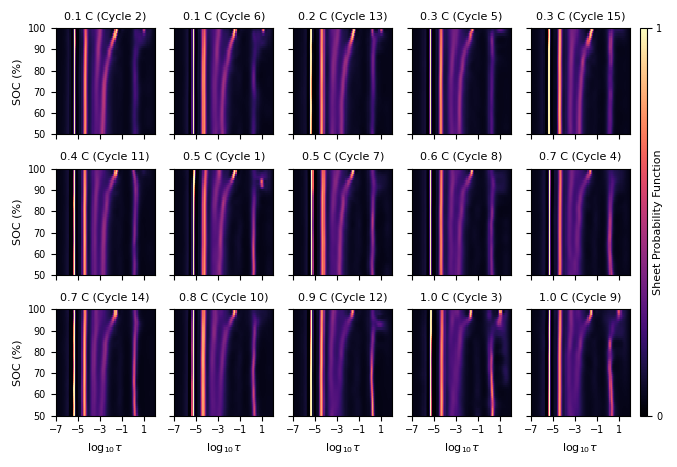

In [200]:
# Sheet probability surfaces
# Sort by C rate first, test_id second
# test_rate_dict = {k: v['c_rate'] for k, v in discharge_data.items()}
get_sort_val = lambda x: test_rate_dict[x] * 100 + x * 0.1
test_id_sort = sorted(list(np.arange(1, 16)), key=get_sort_val)

fig, axes = plt.subplots(3, 5, figsize=(full_width, full_width * 0.69), sharex=True, sharey=True)

for i, test_id in enumerate(test_id_sort):
    ax = axes.ravel()[i]
    x = struct_results[f'{test_id}_DISCHARGE']['rp_raw']
    
    sm, _ = plot_x_2d(x, soc_grid, mrt_rbf, ax=ax, cmap='magma', alpha=1,
                    vmin=0, vmax=1)
    ax.set_title('{:.1f} C (Cycle {})'.format(test_rate_dict[test_id], test_id), fontsize=8)
    
    
for ax in axes[:, 1:].ravel():
    ax.set_ylabel('')

for ax in axes[:-1].ravel():
    ax.set_xlabel('')
    
fig.tight_layout()

fig.subplots_adjust(right=0.93, wspace=0.2)
bbox1 = axes[0, 4].get_position()
bbox2 = axes[2, 4].get_position()
cax = fig.add_axes([bbox1.x1 + 0.015, bbox2.y0, 0.01, bbox1.y1 - bbox2.y0])
cb = fig.colorbar(sm, cax=cax)
cb.set_ticks([0, 1])
cb.set_label(r'Sheet Probability Function', labelpad=-7)

ff.savefig(fig, 'Supp_LIB_SheetProb2d')

### GP-ZARC validation
Examine the fit quality of the GP-ZARC model.

C rate: 0.3
-0.26543315443445836 0.1392227289118497


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


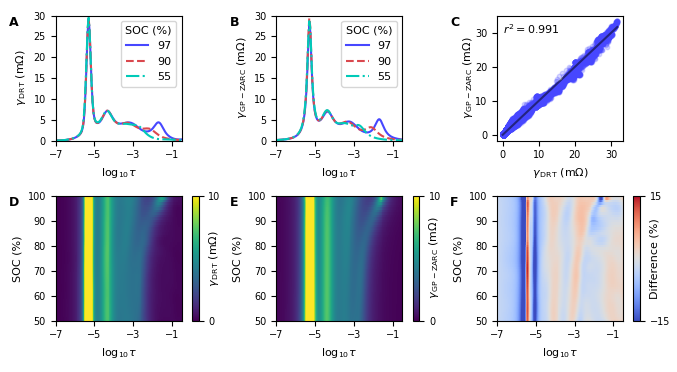

In [201]:
fig, axes = plt.subplots(2, 3, figsize=(full_width, full_width * 0.55))

drt1d_axes = axes[0, :2]
drt2d_ax = axes[1, 0]
rq2d_ax = axes[1, 1]
diff_ax = axes[1, 2]
r2_ax = axes[0, 2]

drt_axes = list(drt1d_axes.ravel()) + [drt2d_ax, rq2d_ax, diff_ax]

drt2d_ax.get_shared_x_axes().join(*drt_axes)
# drt1d_axes[0].get_shared_y_axes().join(*drt1d_axes)

tau_eval = np.logspace(-7, -0.5, 131)

test_id = 5
print('C rate:', discharge_data[test_id]['c_rate'])
stack_index = test_id_list.index(test_id)
res = struct_results[f'{test_id}_DISCHARGE']
x = res['x_filt']
gamma = mrt_rbf.predict_drt(x=x, tau=tau_eval)

f_rq = hybdrt.models.elements.element_distribution_function('RQ')
rq_dist = np.array([f_rq(t, R_stack, lt_stack, beta_stack) for t in tau_eval])
rq_dist = np.moveaxis(rq_dist, 0, -1)
rq_gamma = np.sum(rq_dist, axis=0)


vmin = 0
vmax = 10

# DRT surface
plot_drt_2d(1000 * x, soc_grid, mrt_rbf, tau=tau_eval, ax=drt2d_ax, vmin=vmin, vmax=vmax)

# GP-ZARC surface
sm_drt, _ = plot_x_2d(1000 * rq_gamma[stack_index], soc_grid, mrt_rbf, tau=tau_eval, ax=rq2d_ax, 
                  vmin=vmin, vmax=vmax)

# Surface difference
diff = gamma - rq_gamma[stack_index]
diff /= (gamma + np.std(gamma))
print(np.min(diff), np.max(diff))

sm_diff, _ = plot_x_2d(100 * diff, soc_grid, mrt_rbf, tau=tau_eval, ax=diff_ax, 
                       vmin=-15, vmax=15, cmap='coolwarm')

# 1d DRTs for clarity
ls = ['-', '--', '-.']
for ii, i in enumerate([47, 40, 5]):
    line_kw = dict(c=light_colors[ii], ls=ls[ii], label='{:.0f}'.format(soc_grid[i] * 100))
    drt1d_axes[0].plot(np.log10(tau_eval), 1000 * gamma[i], **line_kw)
    drt1d_axes[1].plot(np.log10(tau_eval), 1000 * rq_gamma[stack_index, i], **line_kw)
    
for ax in drt1d_axes:
    ax.legend(title='SOC (%)')
    ax.set_ylim(0, 30)
    ax.set_xlabel(r'$\log_{10}\tau$')
    
drt1d_axes[0].set_ylabel('$\gamma_{\, \mathrm{DRT}}$ (m$\Omega$)')
drt1d_axes[1].set_ylabel('$\gamma_{\, \mathrm{GP-ZARC}}$ (m$\Omega$)')


# Limit surface plots to non-transport region
axes[0, 0].set_xlim(-7, -0.5)

for ax in drt_axes:
    ax.set_xticks(np.arange(-7, -0.5, 2))

# Plot predicted vs. actual using 10 ppd to match input data
rq_dist = np.array([f_rq(t, R_stack, lt_stack, beta_stack) for t in mrt_rbf.tau_supergrid[:lf_index]])
rq_dist = np.moveaxis(rq_dist, 0, -1)
rq_gamma = np.sum(rq_dist, axis=0)

y_drt = f_stack[..., :lf_index].flatten()
y_rq = rq_gamma.flatten()

r2_ax.scatter(1000 * y_drt, 1000 * y_rq, s=10, alpha=0.2, c=light_colors[0])
y_lin = [0, 1000 * np.max(y_drt)]
r2_ax.plot(y_lin, y_lin, c='k', alpha=0.5)

# Report r2 score
r2 = r2_score(y_drt, y_rq)
r2_ax.text(0.05, 0.95, '$r^2 = {:.3f}$'.format(r2), transform=r2_ax.transAxes, ha='left', va='top')
r2_ax.set_xlabel('$\gamma_{\, \mathrm{DRT}}$ (m$\Omega$)')
r2_ax.set_ylabel('$\gamma_{\, \mathrm{GP-ZARC}}$ (m$\Omega$)', labelpad=0)

fig.tight_layout()

# Add colorbars
fig.subplots_adjust(right=0.92, wspace=0.75)

# DRT colorbar
cb_width = 0.01
cb_sep = 0.015
caxes = []
for ax in [drt2d_ax, rq2d_ax, diff_ax]:
    bbox = ax.get_position()
    caxes.append(fig.add_axes([bbox.x1 + cb_sep, bbox.y0, cb_width, bbox.height]))
    
for i, cax in enumerate(caxes[:2]):
    cb_drt = fig.colorbar(sm_drt, cax=cax)
    cb_drt.set_ticks([0, 10])
    if i == 0:
        cb_drt.set_label(r'$\gamma_{\, \mathrm{DRT}}$ (m$\Omega$)', labelpad=-10)
    else:
        cb_drt.set_label(r'$\gamma_{\, \mathrm{GP-ZARC}}$ (m$\Omega$)', labelpad=-10)

cb_diff = fig.colorbar(sm_diff, cax=caxes[2])
cb_diff.set_ticks([-15, 15])
cb_diff.set_label(r'Difference (%)', labelpad=-15)

# loci = [(-0.33, 1)] * 3 + [(-0.29, 1)]
ff.add_letters(axes, loc=(-0.37, 1))

ff.savefig(fig, 'Supp_LIB_GPZARC_Validation')